# Adaboost for Regression (R2)

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

While boosting is a techinque that is origins in classification, there is a variant of it that can also be used for regression. In this notebook we present the most popular algorithm, give an implementation from scratch and reconcile it with the popular [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).

# R2 Algorithm
The R2 algorithm is one implementation of the idea of boosting for regression. The steps are as follows.

## Fitting

**Input:** 
* Labeled dataset $(X,y) = (x_i,y_i)_{i=1, \ldots, N}$, $x_i \in \mathbb{R}^d$, $y_i \in \mathbb{R}$
* $T \in \mathbb{N}$ the number of weak learners

**Notation:**
We denote by $t=1, \ldots, T$ the index of the weak learner in step $t$. For each step we denote by
* $f_t:\mathbb{R}^n \to \mathbb{R}$ the prediction function of learner $t$
* $w_t \in \mathbb{R}^N$ the vector of weights corresponding to the $N$ samples $x_i$, $i=1, \ldots, N$
* $\alpha_t \in \mathbb{R}$ the weight that learner $t$ will have in the final prediction
* $\varepsilon_t \in \mathbb{R}$ the error of learner $t$


**Steps:** We initialize the weights as uniform, i.e. 
\begin{align*}
    \forall 1 \leq i \leq N: w_{1,i} := \frac{1}{N}.
\end{align*}

For each step $t=1, \ldots, T$, we perform the following tasks:
1. **Train the weak estimator** $t$ on the training set $(X_i, y_i)$, $i=1, \ldots, N$ using the weight vector $w_t$ (see explainations below for more details).
2. Compute the **absolute prediction error** of each sample, i.e. 
\begin{align*}
    \hat e_{t,i} := |y_i - f_t(x_i)|
\end{align*}
and then normalize via
\begin{align*}
    e_{t,i} := \frac{\hat e_{t,i}}{\hat e_{t,max}} && e_{t,\max} := \max_{i}|y_i - f_t(x_i)|.
\end{align*}
3. Compute the ratio **weighted error** of estimator $t$ on the training set:
 \begin{align*}
    E_t := \sum_{i=1}^N{w_{t,i} e_{t,i}}.
 \end{align*}
5. Compute the ratio
   \begin{align*}
       \beta_t := \frac{E_t}{1-E_t}
   \end{align*}
   and then using this the **estimator weight** for learner $t$:
   \begin{align*}
       \alpha_t := \ln\Big(\frac{1}{\beta_t}\Big) = \ln\Big(\frac{1-E_t}{E_t}\Big)
   \end{align*}
7. Calculate **new weights** for the next step of the iteration:
   \begin{align*}
       \forall 1 \leq i \leq N: \hat w_{t+1,i} := w_{t,i} \exp(\beta_t^{1-e_{t,i}}) && w_{t,i} := \frac{\hat w_i}{\sum_{i=1}^N{\hat w_{t,i}}} \in [0,1].
   \end{align*}

## Prediction
After fitting, the prediction function $F:\mathbb{R}^d \to \mathbb{R}$ on $x$ is defined as the [weighted median](https://en.wikipedia.org/wiki/Weighted_median) of the individual estimator predictions $(f_1(x), \ldots, f_T(x))$ using the estimator weights $(\alpha_1, \ldots, \alpha_T)$.

# Weak Estimator Training
The first step is to train the weak regressor using the weights. There are two fundamentally different ways to do this:

1. **Bootstrap sampling:** Instead of training the regressor on the training data $(x_i, y_i)$, $i=1, \ldots, N$, we instead produce a *bootstrap sample*, i.e. we draw (with replacement) $N$ times at random from the training data, and the probability to draw any given sample $i$ is the weight $w_{t,i}$. This principle has the advantage that it operates only on the data itself, i.e. it is agnostic as to which precise regressor is chosen. It has the disadvantage that the weak regressor is not aware of the weighting and hence cannot take this into account in a way that is somewhat more tailored to the regressor itself. Notice that while each regressor is trained on a different the bootstrap sample, the error is still calculated using the same original traning sample for all regressors.
2. **Train with weights:** Many regressors have the option of supplying weights to the training process and hence can take them into account in a way that better fits their training process. The precise way of how this is done depends on the regressor.

The [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html) uses the bootstrap sampling, so it works in theory with any weak regressor chosen. The standard regressor is a [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor) of ``max_depth=3``.


# Reconciliation
We provide a naive implementation of R2 from scratch and reconcile with the ``sklearn`` implementation.

In [2]:
class AdaBoostR2Custom:

    def __init__(self, estimator_type):
        self.estimator_type = estimator_type
        self.estimators_ = None
        self.estimator_weights_ = None
        self.estimator_errors_ = None
        self.sample_weights_ = None
        self.estimator_predictions_ = None
        self.exp_loss_history_ = None

    def fit(self, X, y, estimator_params, seed=42):
        n_samples = X.shape[0]
        n_estimators = len(estimator_params)
        current_weights = np.ones(n_samples) / n_samples  # Initialize uniform sample weights

        # log intermediate results for reconciliation
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(n_estimators)
        self.estimator_errors_ = np.zeros(n_estimators)
        self.sample_weights_ = np.zeros((n_estimators, n_samples))
        self.estimator_predictions_ = np.zeros((n_estimators, n_samples))
        self.exp_loss_history_ = np.zeros(n_estimators)

        # create random state for bootstrap samples
        random_state = np.random.RandomState(seed)

        for t in range(n_estimators):
            # create weak learner
            params = estimator_params[t]
            del params['random_state']
            weak_learner = self.estimator_type(**estimator_params[t])
            dummy = random_state.randint(np.iinfo(np.int32).max)
            # log current sample weights
            self.sample_weights_[t, :] = current_weights

            # create bootstrap sample (the fixed random state is only needed for reconciliation)

            bootstrap_idx = random_state.choice(
                np.arange(n_samples),
                size=n_samples,
                replace=True,
                p=current_weights
            )
            X_bootstrap = X[bootstrap_idx]
            y_bootstrap = y[bootstrap_idx]

            weak_learner.fit(X_bootstrap, y_bootstrap)
            predictions = weak_learner.predict(X)

            # compute absolute error
            errors = np.abs(y - predictions)
            errors /= errors.max()

            weighted_error = (errors * current_weights).sum()

            # compute beta
            beta = weighted_error / (1 - weighted_error)

            # compute estimator weight
            alpha = np.log( 1 / beta )

            # Update sample weights (use unnormalized error directly)
            current_weights *= np.power(beta, 1.0 - errors)

            # Normalize weights
            current_weights /= np.sum(current_weights)

            self.estimators_.append(weak_learner)
            self.estimator_weights_[t] = alpha
            self.estimator_errors_[t] = weighted_error
            self.estimator_predictions_[t, :] = predictions

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.array([estimator.predict(X) for estimator in adaboost_custom.estimators_]).T
        alphas = np.array(adaboost_custom.estimator_weights_)
        sort_idx = np.argsort(predictions, axis=1)
        alpha_cum = np.cumsum(alphas[sort_idx], axis=1)
        median_idx = np.array([np.searchsorted(ac, 0.5 * ac[-1]) for ac in alpha_cum])
        median_estimators = sort_idx[:, median_idx]
        return np.array([predictions[i, sort_idx[i, :][median_idx[i]]] for i in range(n_samples)])

In [3]:
# generate synthetic regression dataset
n_samples = 200
X, y = make_regression(n_samples=n_samples, n_features=1, noise=15, random_state=42)

# train sklearn AdaBoostRegressor 
n_estimators = 50
adaboost_sklearn = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=3), 
                                n_estimators=n_estimators, random_state=42)
adaboost_sklearn.fit(X, y)
y_pred_sklearn = adaboost_sklearn.predict(X)

# train custom AdaBoostR2
estimator_params = [estimator.get_params() for estimator in adaboost_sklearn.estimators_]
adaboost_custom = AdaBoostR2Custom(estimator_type=DecisionTreeRegressor)
adaboost_custom.fit(X, y, estimator_params)
y_pred_custom = adaboost_custom.predict(X)

In [4]:
# reconcile estimator errors
np.testing.assert_array_almost_equal(adaboost_custom.estimator_errors_, adaboost_sklearn.estimator_errors_)

# reconcile estimator weights
np.testing.assert_array_almost_equal(adaboost_custom.estimator_weights_, adaboost_sklearn.estimator_weights_)

# reconcile predictions
np.testing.assert_array_equal(y_pred_sklearn, y_pred_custom)

In [5]:
# evaluate both models
custom_mae = mean_absolute_error(y, y_pred_custom)
sklearn_mae = mean_absolute_error(y, y_pred_sklearn)

In [6]:
sklearn_mae, sklearn_mae

(11.643123713375756, 11.643123713375756)

# Example
We provide an example of an application of the method in the case where
\begin{align*}
    y_i = \sin(x_i) + \varepsilon_i.
\end{align*}

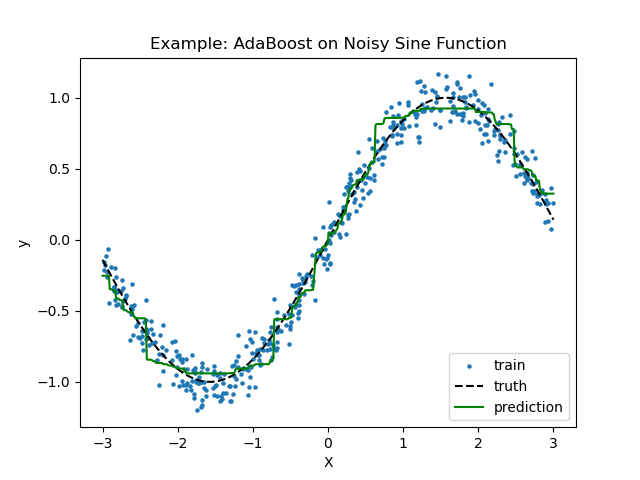

In [7]:
# generate synthetic dataset
np.random.seed(2)
n_samples = 500
eps_var = 0.1
X = np.random.uniform(-3, 3, n_samples).reshape(-1, 1) 
y = np.sin(X).flatten() + np.random.normal(0, eps_var, size=X.shape[0])

# sort X for smooth plotting
X_test = np.linspace(-3, 3, 500).reshape(-1, 1)
y_true = np.sin(X_test).flatten()  # True function

# 
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100
)
ada_reg.fit(X, y)
y_pred_boosted = ada_reg.predict(X_test)

# Plot results
plt.figure()
plt.scatter(X, y, label="train", s=5)
plt.plot(X_test, y_true, label="truth", color='k', linestyle='--')
plt.plot(X_test, y_pred_boosted, label="prediction", color='green')
plt.legend(loc='lower right')
plt.xlabel("X")
plt.ylabel("y")
plt.title("Example: AdaBoost on Noisy Sine Function")
plt.show()


# References
* H. Drucker, “Improving Regressors using Boosting Techniques”, 1997
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html